In [12]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from sl_ai.process_videos import ffmpeg_resize, WIDTH, HEIGHT
from time import sleep
import skvideo.io
import skvideo.utils
import keras
from keras.utils import to_categorical
import pandas as pd

In [13]:
DATASET_CUTOFF = 2  # Only select gestures where the dataset is >= DATASET_CUTOFF

lookup = dict()
reverselookup = dict()
ROOT_PATH = Path('../../ai_data/vgt-all-360')
count = 0
for j in os.listdir(ROOT_PATH):
    if not j.startswith('.') and len(os.listdir(ROOT_PATH / j)) >= DATASET_CUTOFF:
        lookup[j] = count
        reverselookup[count] = j
        count += 1
lookup

{'sport - bowlen': 0,
 'sport - fietsen': 1,
 'technologie - computer': 2,
 'land - verenigde staten': 3,
 'land - belgie': 4,
 'communicatie - gebaar': 5,
 'communicatie - hallo': 6,
 'communicatie - duidelijk': 7,
 'dier - geit': 8}

In [14]:
reverselookup

{0: 'sport - bowlen',
 1: 'sport - fietsen',
 2: 'technologie - computer',
 3: 'land - verenigde staten',
 4: 'land - belgie',
 5: 'communicatie - gebaar',
 6: 'communicatie - hallo',
 7: 'communicatie - duidelijk',
 8: 'dier - geit'}

In [15]:
def rescale_list(input_list, size):
    # Does not work for lists shorter than size yet.
    assert len(input_list) >= size
    skip = len(input_list) // size
    output = [input_list[i] for i in range(0, len(input_list), skip)]
    return output[:size]

def read_video(file_path: str, as_grey=False):
    video_data = skvideo.io.vreader(file_path, as_grey=as_grey)
    return list(video_data)

def grayscale_video(video_data):
    # Converts video data to grayscale.
    return skvideo.utils.rgb2gray(video_data)

In [16]:
x_data = []  # All frames in dataset.
y_data = []  # Classes/Gestures of the frames as integers.
frame_count = 0
total_videos = 0
for n, gesture in enumerate(os.listdir(ROOT_PATH)): # Loop over gestures.
    videos = os.listdir(ROOT_PATH / gesture)
    if len(videos) < DATASET_CUTOFF:
        continue

    total_videos += len(videos)
    for person_video in videos: # Loop over persons.
        count = 0
        video_data = read_video(str(ROOT_PATH / gesture / person_video))
        video_data = rescale_list(video_data, 50)
        for frame in video_data:
            x_data.append(frame)
            count += 1
        y_values = np.full((count, 1), lookup[gesture])
        y_data.append(y_values)
        frame_count += count

x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(frame_count, 1) # Res

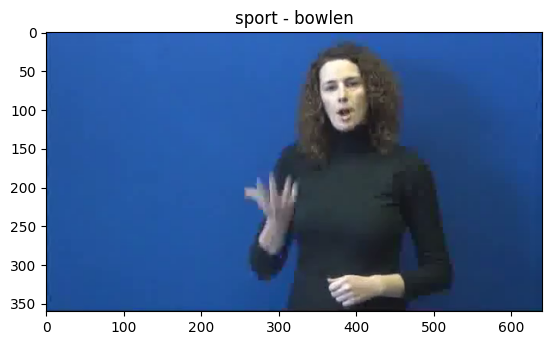

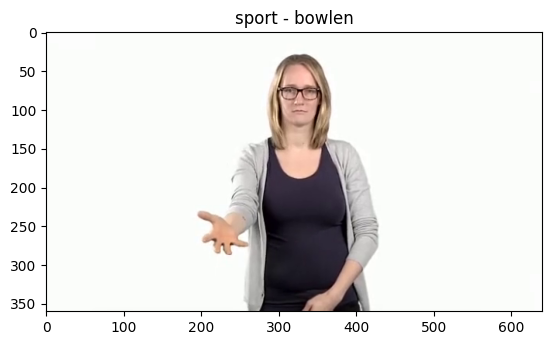

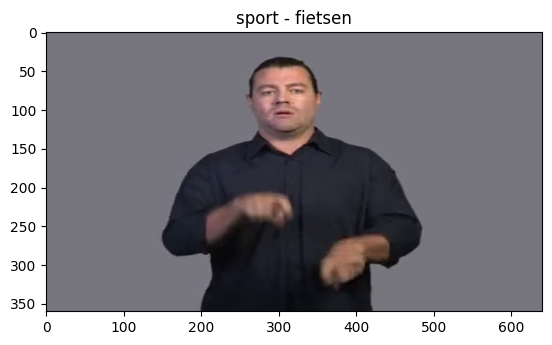

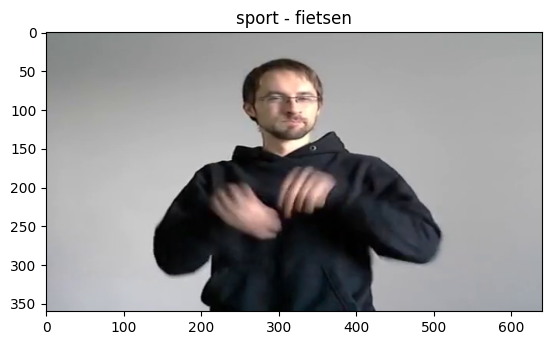

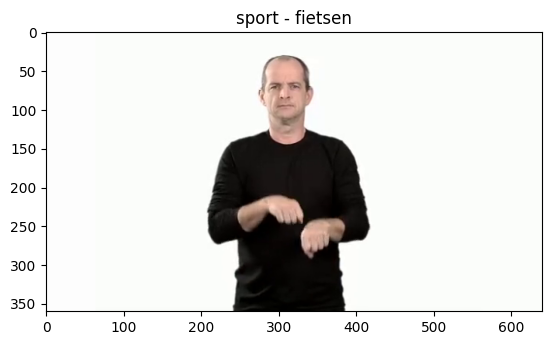

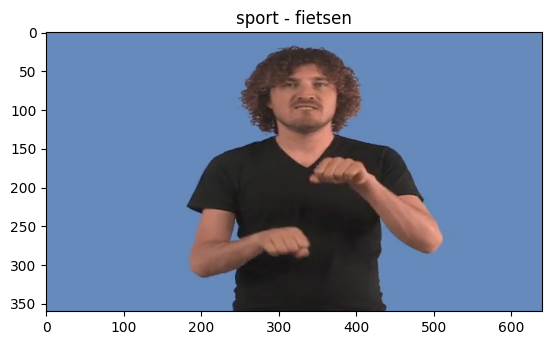

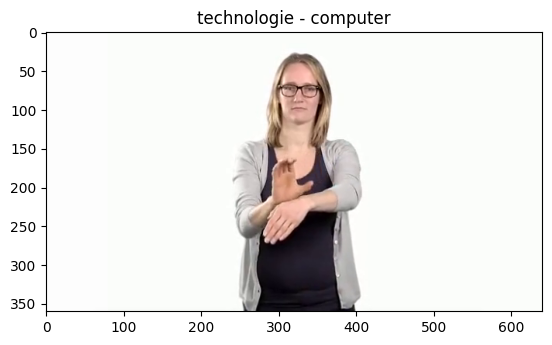

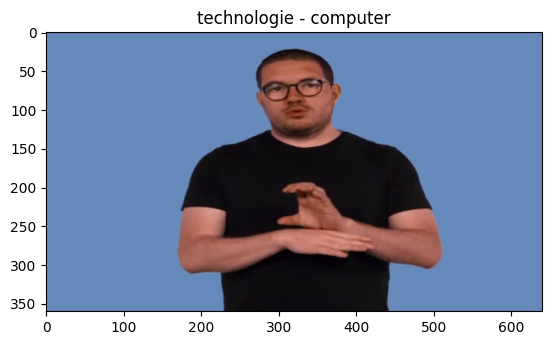

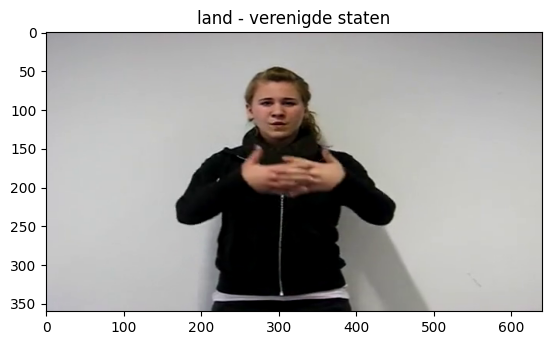

In [17]:
import cv2
# Image colors look distorted but this is only in the preview. The raw data is still correct.
for i in range(0, len(lookup)):
    img_data = x_data[i*50 + 25 , :, :]
    img_data = img_data.astype(np.uint8)
    plt.imshow(img_data)
    plt.title(reverselookup[y_data[i*50+25 , 0]])
    plt.show()

In [21]:
y_data_cat = to_categorical(y_data)
pd.DataFrame(y_data_cat)

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
x_data2 = x_data.reshape((frame_count, 360, 640, 3))
x_data2 /= 255

In [56]:
from sklearn.model_selection import train_test_split
# TODO: THIS IS BAD!!!. A gesture can be split in two by the split function !!!
# TODO: Split the data manually.

x_train,x_further,y_train,y_further = train_test_split(x_data2, y_data_cat, test_size = 0.33)
# Split further vor validation data. Skip this now since the dataset is too small to split further.
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further, test_size = 0.5)
# print(len(x_data2))
# print(len(x_train))
# print(len(x_further))
# print(len(y_train))
# print(len(y_further))
# pd.DataFrame(y_train)

In [57]:
from keras import layers
from keras import models
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(360, 640, 3), name='Conv2D_1'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_1'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='Conv2D_2'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_2'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='Conv2D_3'))
model.add(layers.MaxPooling2D((2, 2), name='MaxPooling2D_3'))
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(128, activation='relu', name='Dense_1'))
model.add(layers.Dense(len(lookup), activation='softmax', name='Dense_2'))

In [58]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

# history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10


2022-10-18 16:04:34.641460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 2.8747 - accuracy: 0.3020

2022-10-18 16:04:58.272967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 26s 1s/step - loss: 2.8747 - accuracy: 0.3020 - val_loss: 1.4670 - val_accuracy: 0.5748
Epoch 2/10
14/14 [==============================] - 16s 1s/step - loss: 0.7712 - accuracy: 0.7830 - val_loss: 0.1146 - val_accuracy: 0.9673
Epoch 3/10
14/14 [==============================] - 13s 943ms/step - loss: 0.1153 - accuracy: 0.9747 - val_loss: 0.0498 - val_accuracy: 0.9813
Epoch 4/10
14/14 [==============================] - 12s 888ms/step - loss: 0.0683 - accuracy: 0.9862 - val_loss: 0.2144 - val_accuracy: 0.9673
Epoch 5/10
14/14 [==============================] - 12s 891ms/step - loss: 0.8833 - accuracy: 0.8576 - val_loss: 0.0246 - val_accuracy: 0.9953
Epoch 6/10
14/14 [==============================] - 12s 875ms/step - loss: 0.0277 - accuracy: 0.9920 - val_loss: 0.0203 - val_accuracy: 0.9907
Epoch 7/10
14/14 [==============================] - 12s 873ms/step - loss: 0.0271 - accuracy: 0.9920 - val_loss: 0.0113 - val_accuracy: 0.9907
Epoch 8/10
14/14

In [64]:
# Used when trained with validation data.
# [loss, acc] = model.evaluate(x_test,y_test,verbose=1)

[loss, acc] = model.evaluate(x_further,y_further,verbose=1)
print("Accuracy:" + str(acc))

14/14 [==============================] - 3s 140ms/step - loss: 0.0068 - accuracy: 0.9977
Accuracy:0.9976690411567688


In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 178, 318, 32)      2432      
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 89, 159, 32)      0         
 D)                                                              
                                                                 
 Conv2D_2 (Conv2D)           (None, 87, 157, 64)       18496     
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 43, 78, 64)       0         
 D)                                                              
                                                                 
 Conv2D_3 (Conv2D)           (None, 41, 76, 64)        36928     
                                                                 
 MaxPooling2D_3 (MaxPooling2  (None, 20, 38, 64)      

In [66]:
# Will give an exception if training was done without validation data. This can be ignored.
def visualize_accuracy():
    """Visualize model accuracy
    """
    if history:
        plt.plot(history.history['accuracy'], label='training accuracy')
        plt.plot(history.history['val_accuracy'], label='testing accuracy')
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()

def visualize_loss():
    """Visualizes model loss"""
    if history:
        plt.plot(history.history['loss'], label='training loss')
        plt.plot(history.history['val_loss'], label='testing loss')
        plt.title('Loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

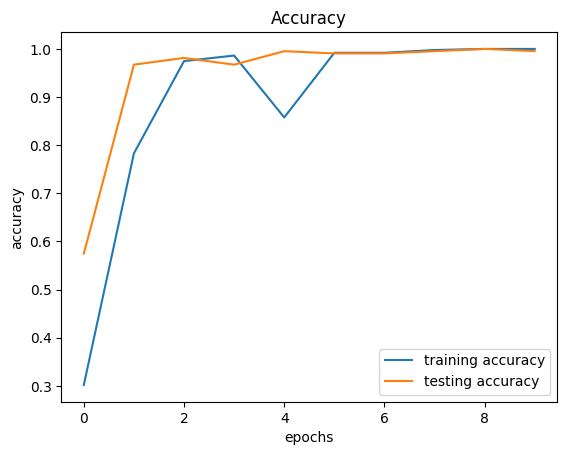

In [67]:
visualize_accuracy()

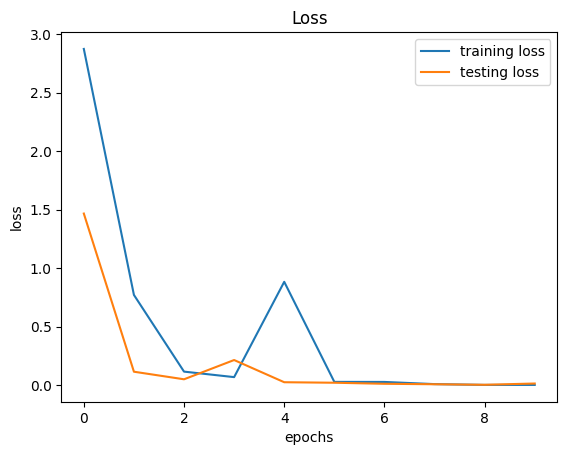

In [68]:
visualize_loss()

In [69]:
model.save('vgt_v1.h5')

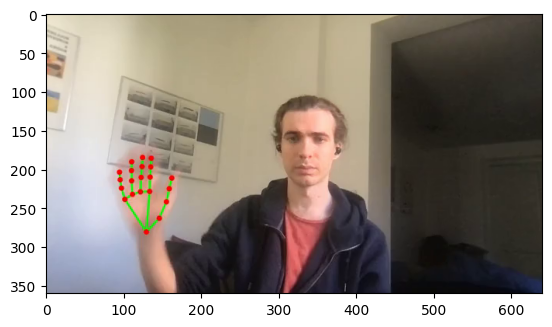

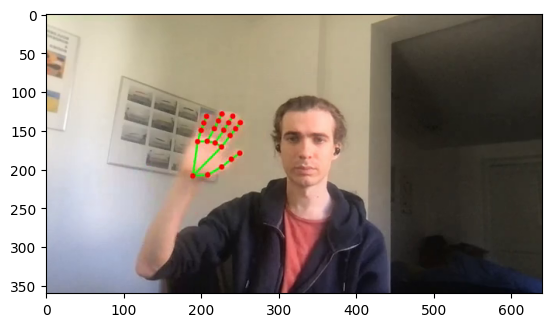

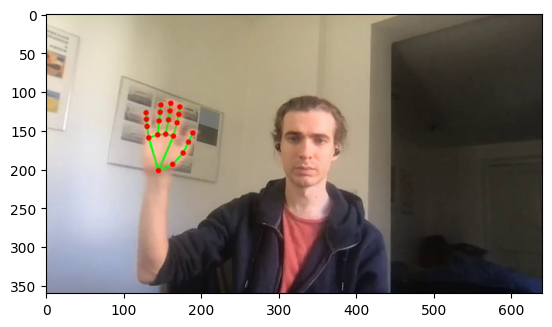

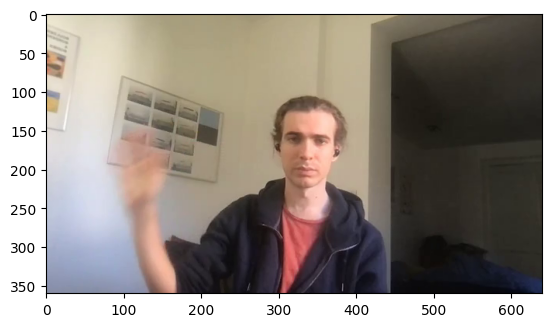

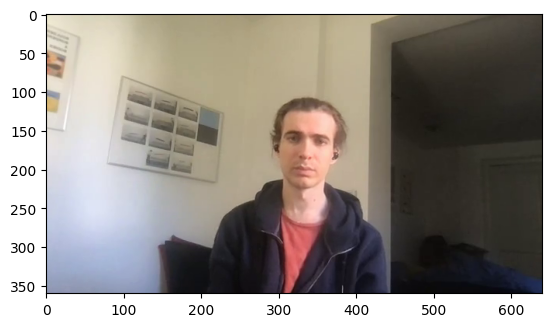

In [87]:
# Should refer to a video NOT part of trained data. Ideally a video from your webcam.
# IMPORTANT: This video needs to be 640x360 resolution and without audio.
# If you have FFMPEG installed a video can be converted using the following command.
#   ffmpeg -y -i <INPUT> -an -vf scale=640:360 -c:v h264 <OUTPUT>
# -ss and -to can be used to trim parts of the video.
#   ffmpeg -y -ss 2 -to 6.2 -i <INPUT> -an -vf scale=640:360 -c:v h264 <OUTPUT>
# change to scale=640:360,hflip to mirror recording.

# input_video = Path(r'../ai_data\vgt-test-360\land - verenigde staten\VERENIGDE-STATEN.mp4')
input_video = Path(r'../../ai_data/camera_recordings/recording.mp4')
video_data = np.array(
    rescale_list(
        read_video(str(input_video)),
        50),
    dtype = 'float32')

for i in range(0, 50, 10):
    frame = video_data[i , :, :]
    frame = frame.astype(np.uint8)
    plt.imshow(frame)
    plt.show()

video_data /= 255

In [88]:
prediction = model.predict(video_data)
classes_x = np.argmax(prediction, axis=1)
print(classes_x)
print('Prediction per frame:')
for i, frame in enumerate(video_data):
    print(f"Frame {i}:", reverselookup[classes_x[i]])
print("----------"*5)
most_common_prediction = np.bincount(classes_x[10:-10]).argmax()
print(f'Predicted that {input_video.name} is gesture "{reverselookup[most_common_prediction]}"')

2/2 [==============================] - 0s 148ms/step
[0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 3 3 3 6 6 6 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]
Prediction per frame:
Frame 0: sport - bowlen
Frame 1: sport - bowlen
Frame 2: sport - bowlen
Frame 3: land - verenigde staten
Frame 4: land - verenigde staten
Frame 5: land - verenigde staten
Frame 6: land - verenigde staten
Frame 7: land - verenigde staten
Frame 8: land - verenigde staten
Frame 9: land - verenigde staten
Frame 10: land - verenigde staten
Frame 11: land - verenigde staten
Frame 12: land - verenigde staten
Frame 13: land - verenigde staten
Frame 14: land - verenigde staten
Frame 15: land - verenigde staten
Frame 16: land - verenigde staten
Frame 17: land - verenigde staten
Frame 18: land - verenigde staten
Frame 19: land - verenigde staten
Frame 20: land - verenigde staten
Frame 21: communicatie - hallo
Frame 22: communicatie - hallo
Frame 23: land - verenigde staten
Frame 24: land - verenigde staten
Frame 25: land 

### Manually analyze the prediction
Columns are classes/gestures, rows are each frame of the video. Values are expressed as percentages.

In [89]:

# pprint(reverselookup)
prediction_percents = (prediction*100)
# prediction_percents[prediction_percents < 5] = None
pd.DataFrame(prediction_percents.astype(np.uint8), columns=[(v.split(" - ")[-1]) for k, v in reverselookup.items()])

,bowlen,fietsen,computer,verenigde staten,belgie,gebaar,hallo,duidelijk,geit
0,31,1,15,29,0,2,17,1,1
1,31,1,15,29,0,2,17,1,1
2,31,1,15,29,0,2,17,1,1
3,8,1,29,35,0,0,23,0,0
4,8,1,29,35,0,0,23,0,0
5,0,0,5,76,0,0,13,1,0
6,0,0,5,74,0,0,15,1,0
7,0,0,0,90,0,1,5,1,0
8,0,0,0,92,0,0,3,1,0
9,0,0,0,92,0,0,3,1,0


Quickly see a preview of a frame at the specified index.

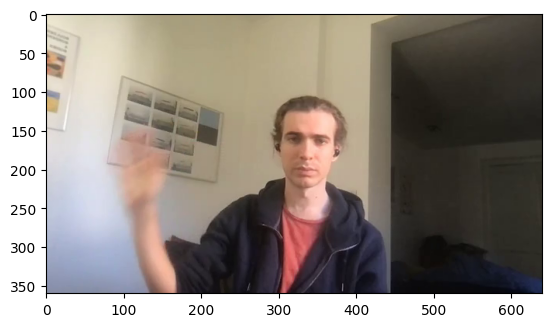

In [91]:
frame_to_preview = 30
frame = video_data[frame_to_preview , :, :]
frame *= 255
frame = frame.astype(np.uint8)
plt.imshow(frame)
plt.show()

In [34]:
prediction_percents = (prediction*100)
pd.DataFrame(prediction_percents.astype(np.uint8), columns=reverselookup.values())

,sport - bowlen,sport - fietsen,technologie - computer,land - verenigde staten,land - belgie,communicatie - gebaar,communicatie - hallo,communicatie - duidelijk,dier - geit
0,0,0,0,90,0,9,0,0,0
1,0,0,0,86,0,13,0,0,0
2,0,0,1,70,0,27,0,0,0
3,0,0,2,50,0,46,0,0,0
4,0,0,2,44,0,52,0,0,0
5,0,0,2,41,0,55,0,0,0
6,0,0,2,41,0,56,0,0,0
7,0,0,2,39,0,57,0,0,0
8,0,0,2,37,0,59,0,0,0
9,0,0,1,44,0,53,0,0,0


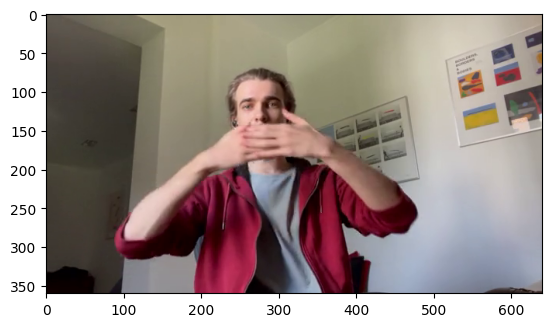

In [71]:
frame_to_preview = 35
frame = video_data[frame_to_preview , :, :]
frame *= 255
frame = frame.astype(np.uint8)
plt.imshow(frame)
plt.show()